4. Finally, combine the time series information from the two datasets together to see how well correlated heavy job-completion load is with the unresponsiveness, and to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

In [1]:
from datetime import datetime
from sqlalchemy import create_engine, select, Table, MetaData
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mpl_dates
import pandas as pd
import numpy as np
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Initialize SQL engine for pulling down data and reflect tables.
engine = create_engine('sqlite:///data/jobs.db')
connection = engine.connect()

metadata = MetaData()

jobs_corrected = Table('jobs_corrected', metadata, autoload = True, autoload_with = engine)
slurm_corrected = Table('slurm_corrected', metadata, autoload = True, autoload_with = engine)

In [3]:
# Pull initial columns from database for overlay on top of each other. i.e., jobs vs. unresponsiveness by time.
end_times = pd.read_sql("SELECT STRFTIME('%Y-%m-%dT%H:%M:%S', END) AS END FROM jobs_corrected",
                        con = connection,
                        parse_dates = ['END'])

unresponsive = pd.read_sql("SELECT UNRESPONSIVE, STRFTIME('%Y-%m-%dT%H:%M:%S', DATETIME)\
AS DATETIME FROM slurm_corrected", 
                           con = connection, 
                           parse_dates = ['DATETIME'])

In [4]:
# Group each set of columns by week and merge on datetime.
# Make pd.Grouper consistent on origin.
end_times['HOURCOUNT'] = ''
end_times = (
    end_times.set_index('END').\
    resample('1H').\
    count().\
    reset_index().\
    rename(columns = {'END':'Hour',
                     'HOURCOUNT': 'Completions Per Hour'})
)

In [5]:
unresponsive = (
    unresponsive.set_index('DATETIME').\
    groupby(pd.Grouper(freq = '1H'))['UNRESPONSIVE'].\
    agg(['sum']).\
    reset_index().\
    rename(columns = {'sum':'Unresponsive Counts',
                     'DATETIME':'Hour'}))

In [6]:
unending = end_times.merge(unresponsive, on = 'Hour')

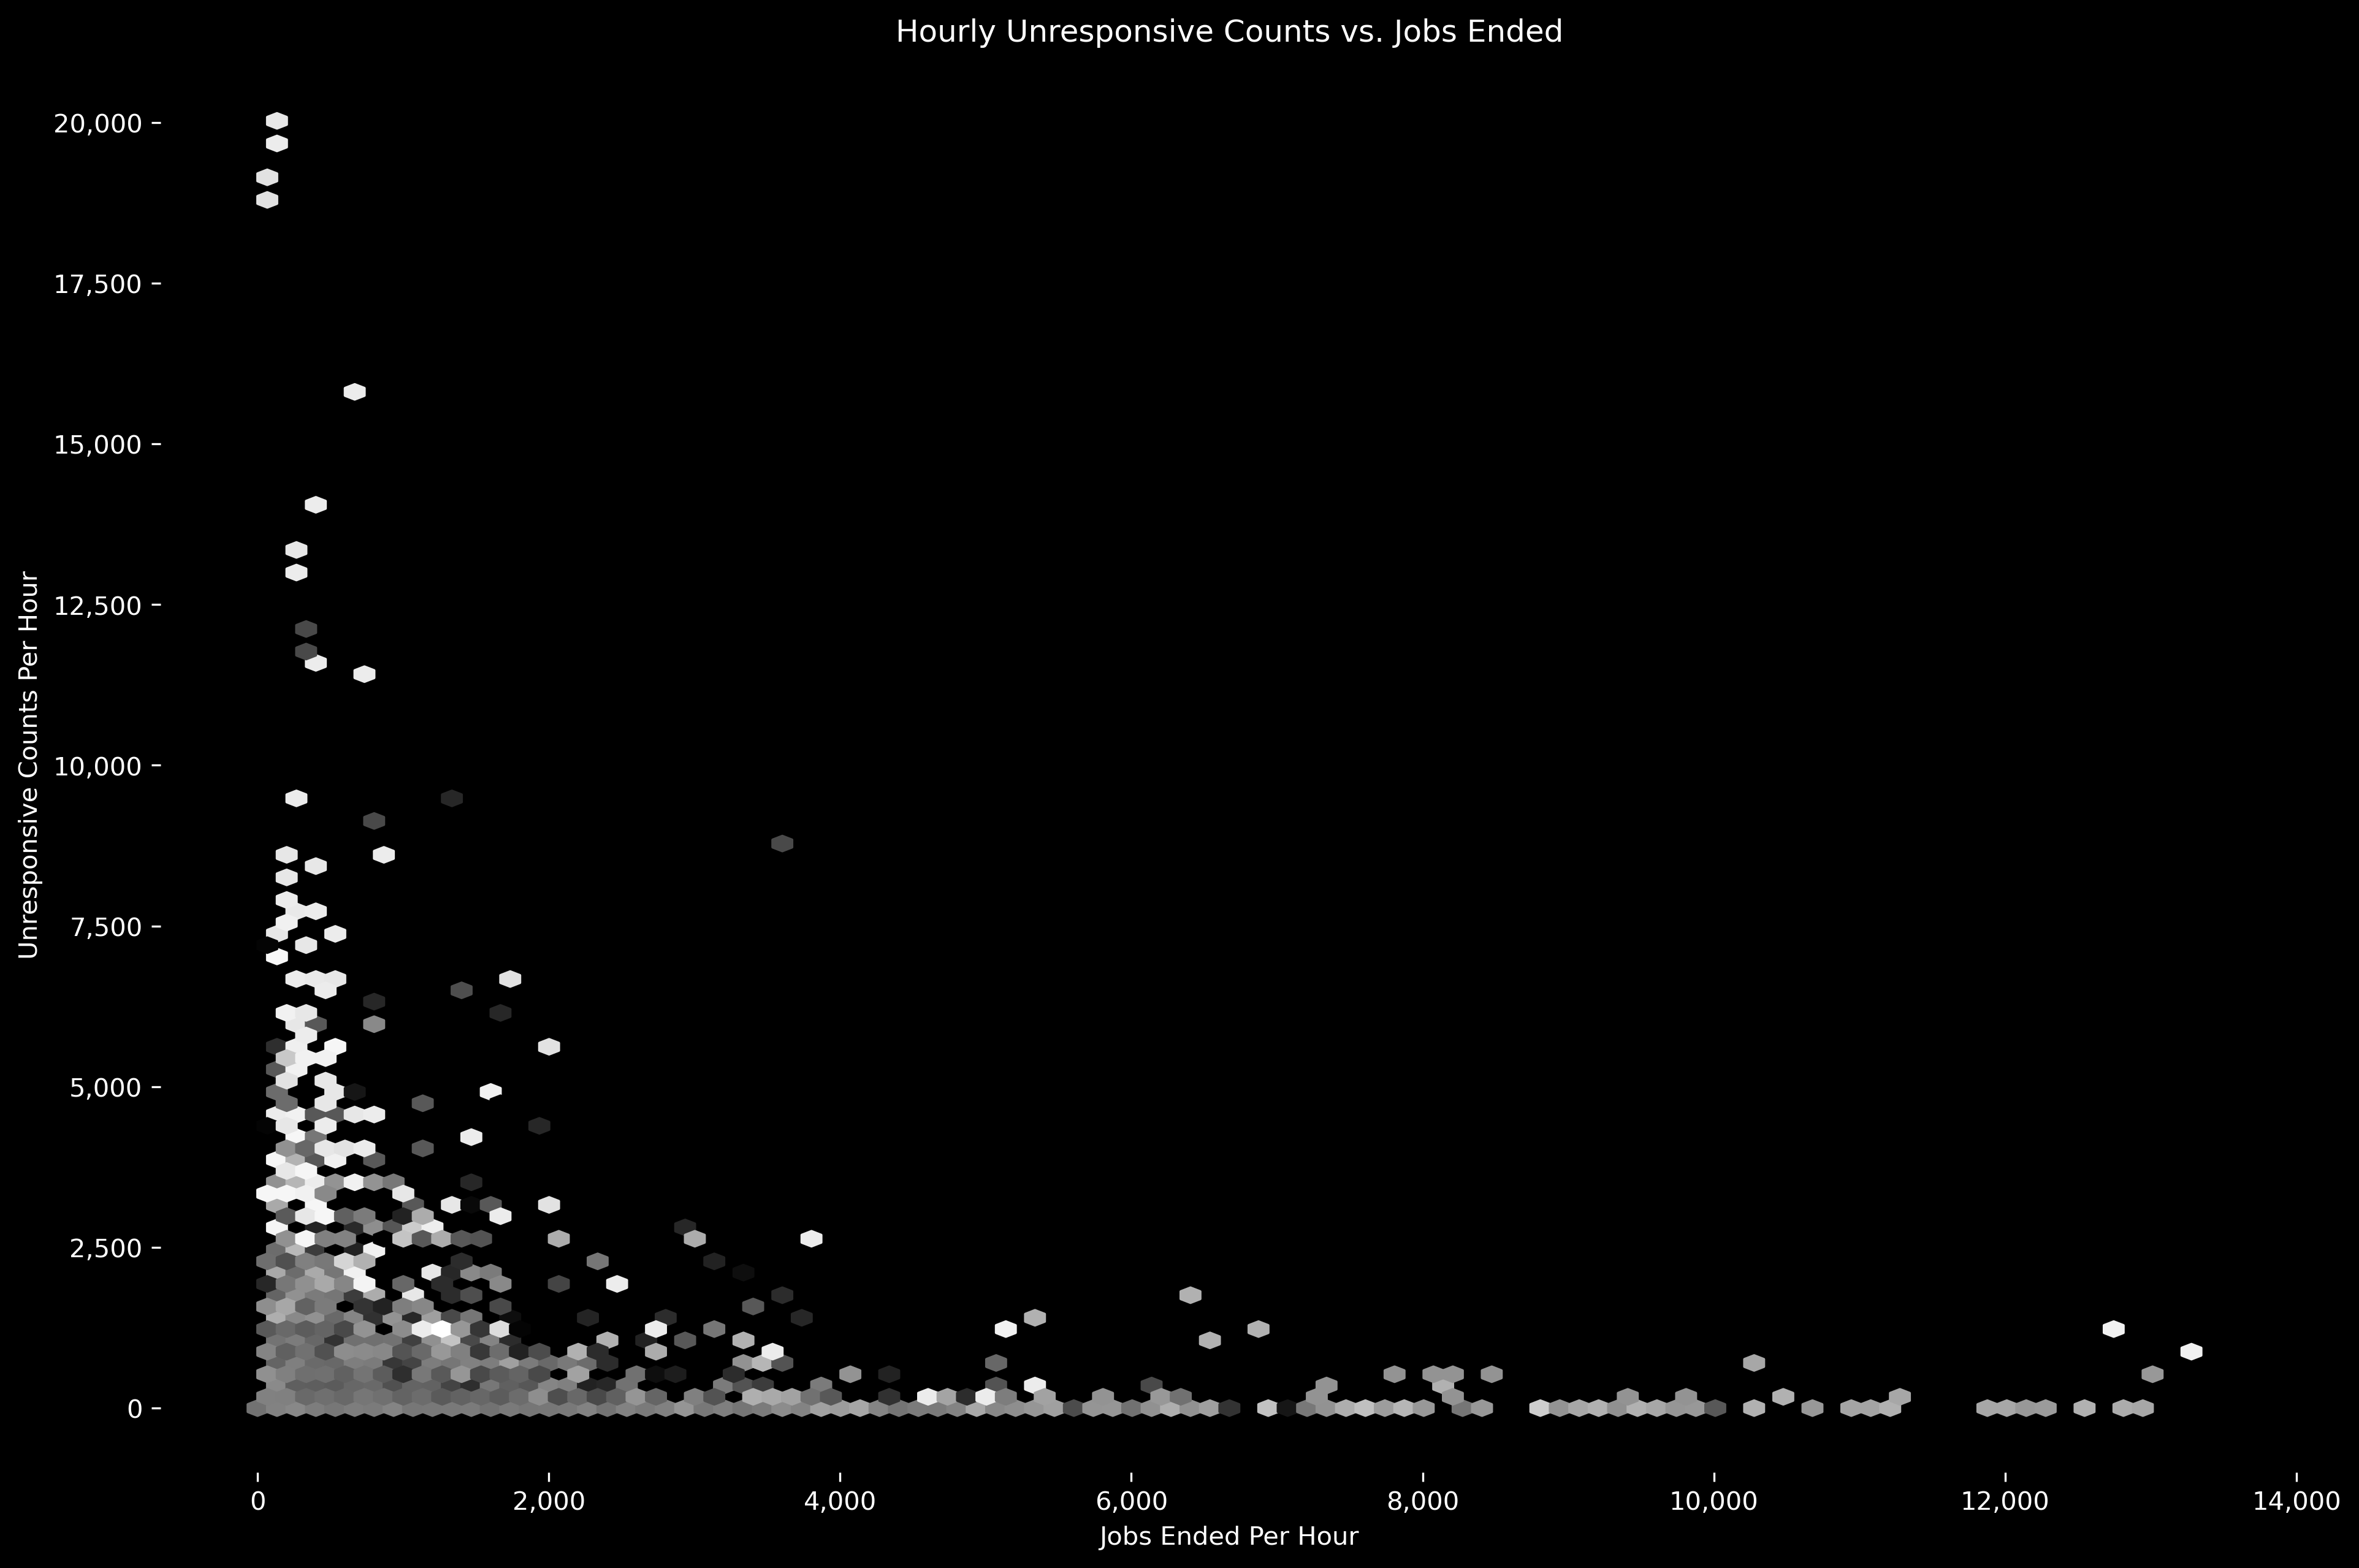

In [7]:
# Plot hexbin chart showing negative correlation between Completions Per Hour and Unresponsive Counts.
plt.rcdefaults()

def thousands_commas_please(ax, *args):
    if 'x' in args:
        ax.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
    if 'y' in args:
        ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

x = unending['Completions Per Hour']
y = unending['Unresponsive Counts']

def make_a_hexbin(x, y):
    fig, ax = plt.subplots(figsize = (15, 10), dpi = 300, facecolor = 'k')
    plt.hexbin(x = x, 
               y = y, 
               C = [i.isocalendar()[1] for i in unending['Hour']], 
               cmap = 'gray')
    ax.set_facecolor('k')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    thousands_commas_please(ax, 'x', 'y')
    ax.tick_params(colors ='white', which = 'both')
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(False)

make_a_hexbin(x,y)
plt.xlabel('Jobs Ended Per Hour')
plt.ylabel('Unresponsive Counts Per Hour')
plt.grid(False)
plt.title('Hourly Unresponsive Counts vs. Jobs Ended', color = 'white')
plt.savefig('images/endtimeshexbin.png', dpi = 800, transparent = False)

In [8]:
# Regroup completions per hour and unresponsive counts by week.
column_list = ['Completions Per Hour','Unresponsive Counts']

unending_by_week = (
    unending.set_index('Hour').\
    groupby(pd.Grouper(freq = 'W'))[column_list].\
    agg(['sum']).\
    reset_index().\
    rename(columns = {'Hour':'Week',
                     'Completions Per Hour': 'Completions Per Week'}))

In [9]:
# Minmax columns for fill between to show difference.
unending_by_week['Completions Per Week MinMax'] = (
    unending_by_week['Completions Per Week']['sum'].\
    apply(lambda x: (x - unending_by_week['Completions Per Week'].min())/\
         (unending_by_week['Completions Per Week'].max() - \
          unending_by_week['Completions Per Week'].min()))
)

unending_by_week['Unresponsive Counts MinMax'] = (
    unending_by_week['Unresponsive Counts']['sum'].\
    apply(lambda x: (x - unending_by_week['Unresponsive Counts'].min())/\
         (unending_by_week['Unresponsive Counts'].max() - \
          unending_by_week['Unresponsive Counts'].min()))
)

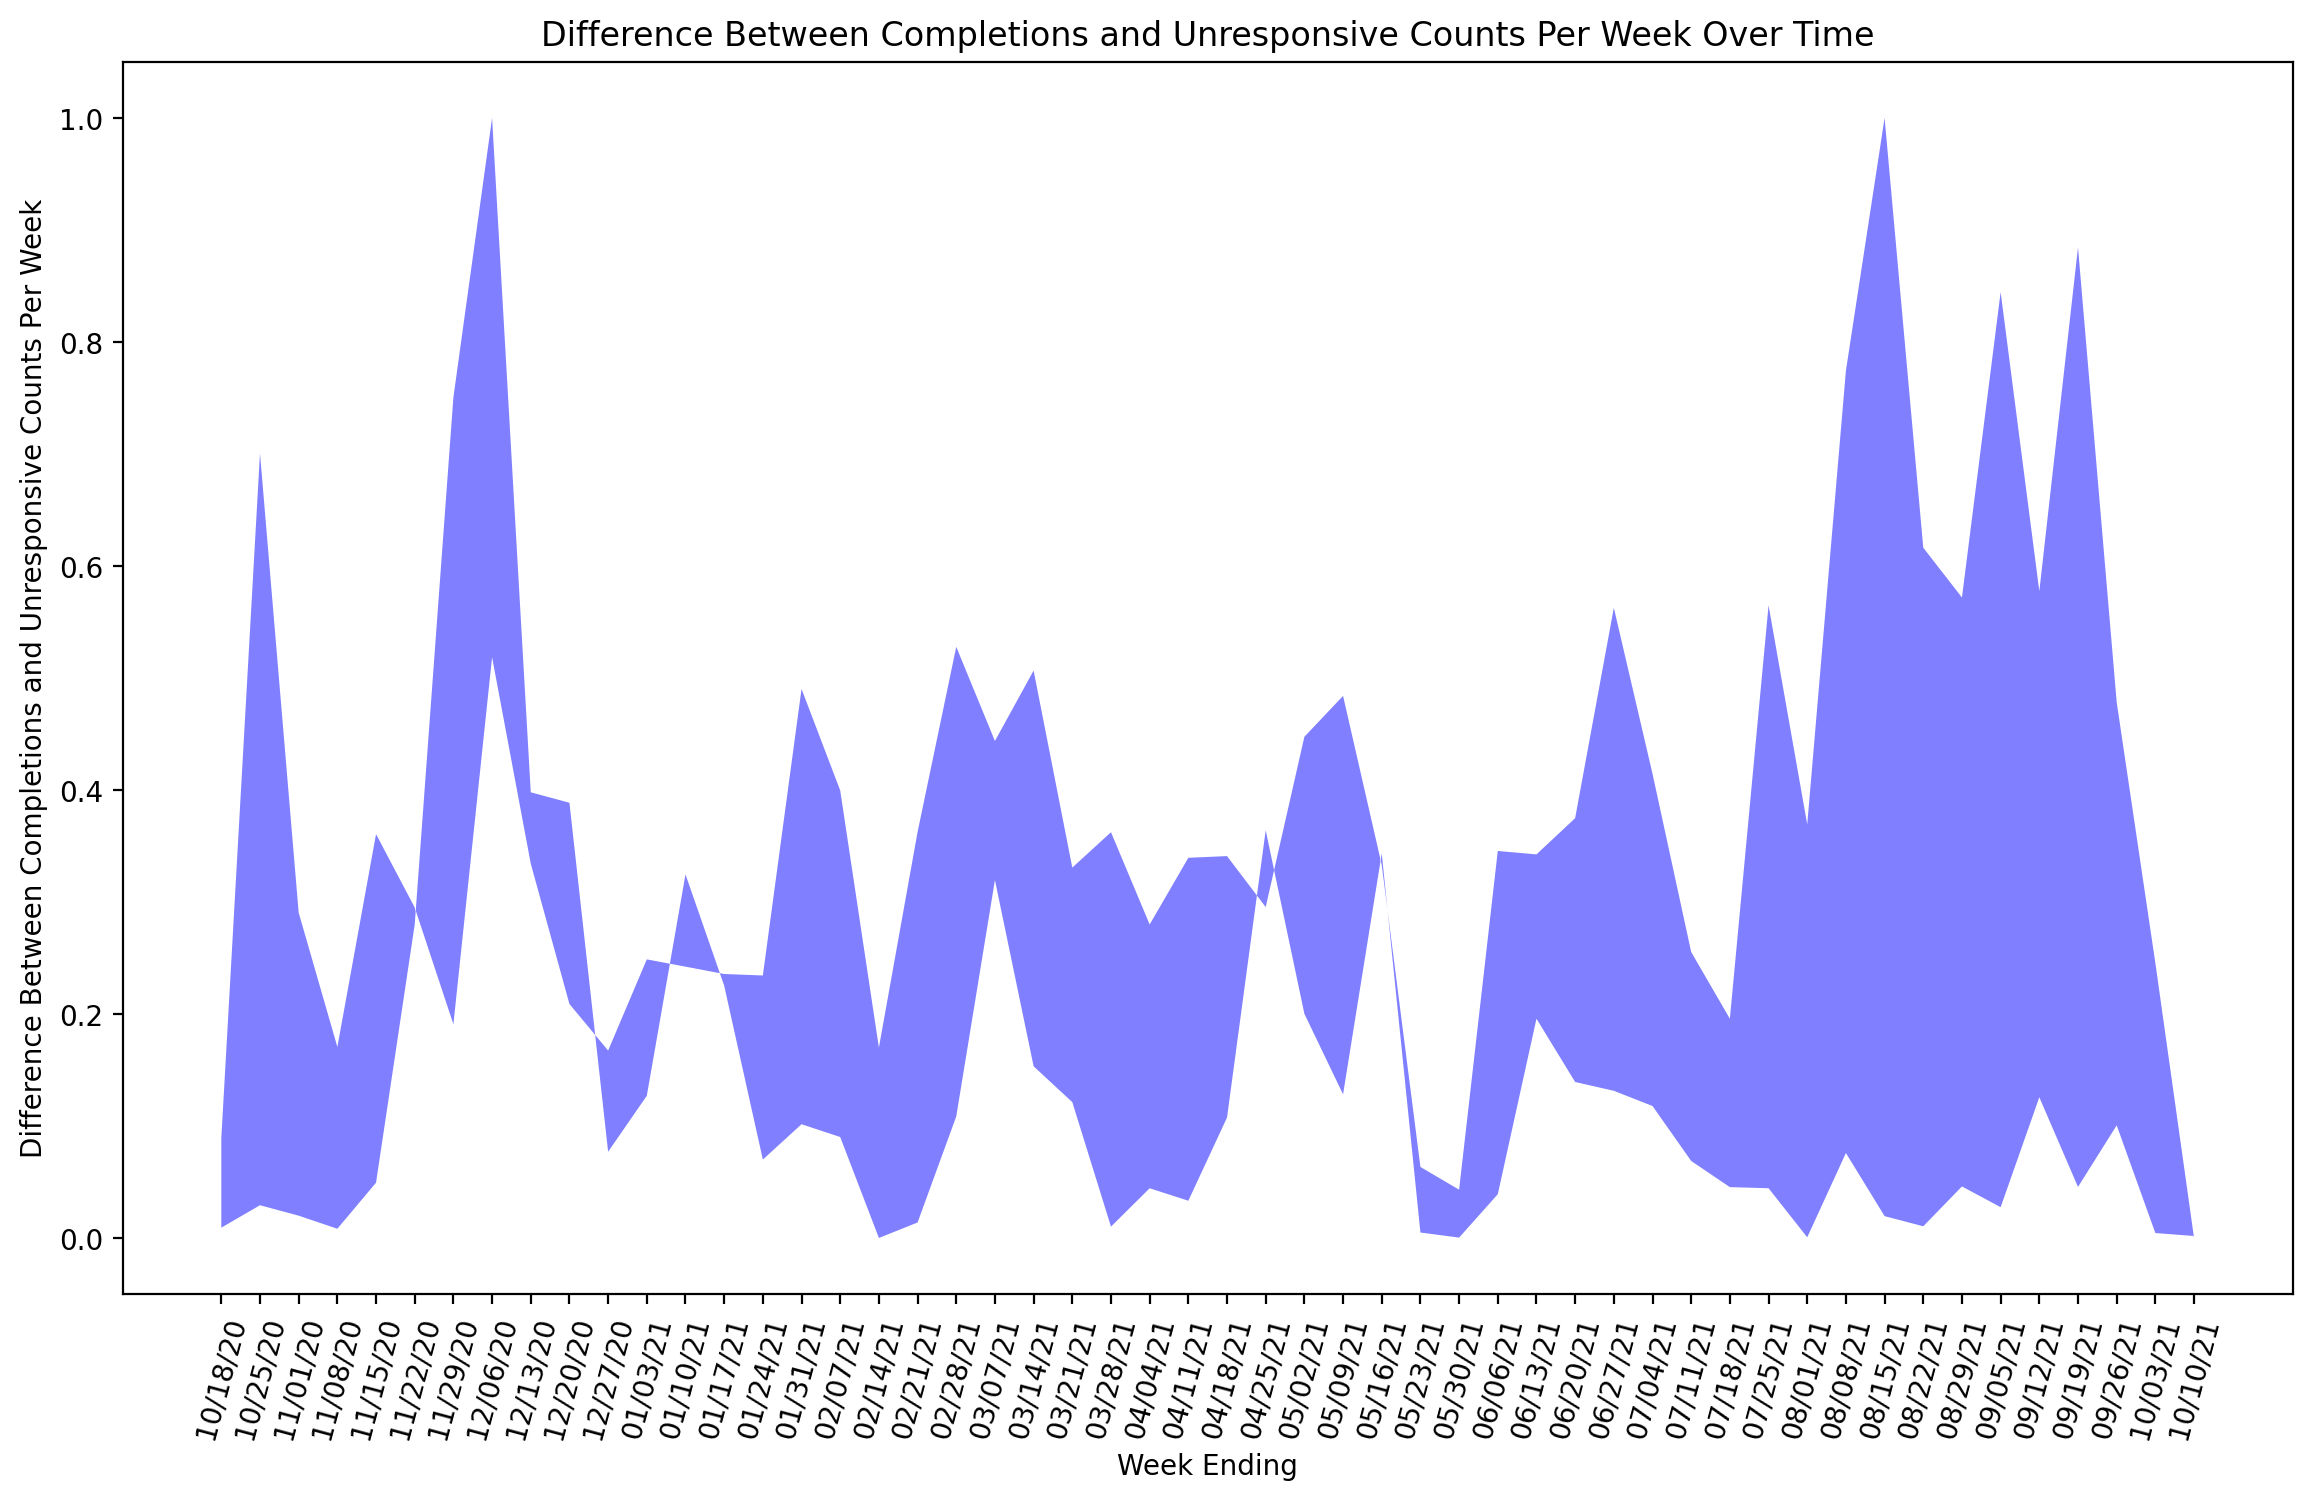

In [10]:
# Create fill between plot showing relative difference between completions per week and unresponsive counts.
facecolor = 'white'
fig, ax = plt.subplots(figsize=(14,8), 
                       facecolor = facecolor,
                      dpi = 200)

y1 = unending_by_week['Completions Per Week MinMax']
y0 = unending_by_week['Unresponsive Counts MinMax']
x = unending_by_week['Week']

ax.fill_between(x, y0, y1, facecolor = 'blue', alpha = 0.5)

plt.xticks(x, rotation = 75, fontsize = 10)
plt.xlabel('Week Ending')
plt.ylabel('Difference Between Completions and Unresponsive Counts Per Week')
plt.title('Difference Between Completions and Unresponsive Counts Per Week Over Time')
ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%D'));

In [11]:
# Consider importing from the Question 1 Jupyter Notebook.
# Pull down SQL columns.
vague_memory = pd.read_sql("SELECT USEDMEMPERCORE, STRFTIME('%Y-%m-%dT%H:%M:%S', END) AS END FROM jobs_corrected",
                           con = connection,
                           parse_dates = ['END'])

In [12]:
# Group total and standard deviation of used memory per core per hour and save as a dataframe.
vague_memory_by_hour = (
    vague_memory.set_index('END').\
    groupby(pd.Grouper(freq = '1H'))['USEDMEMPERCORE'].\
    agg(['sum','std']).\
    reset_index().\
    rename(columns = {'END':'Hour',
                     'sum':'Total Memory Per Core',
                     'std':'Std. Dev. of Total Memory Per Core'}).\
    round())

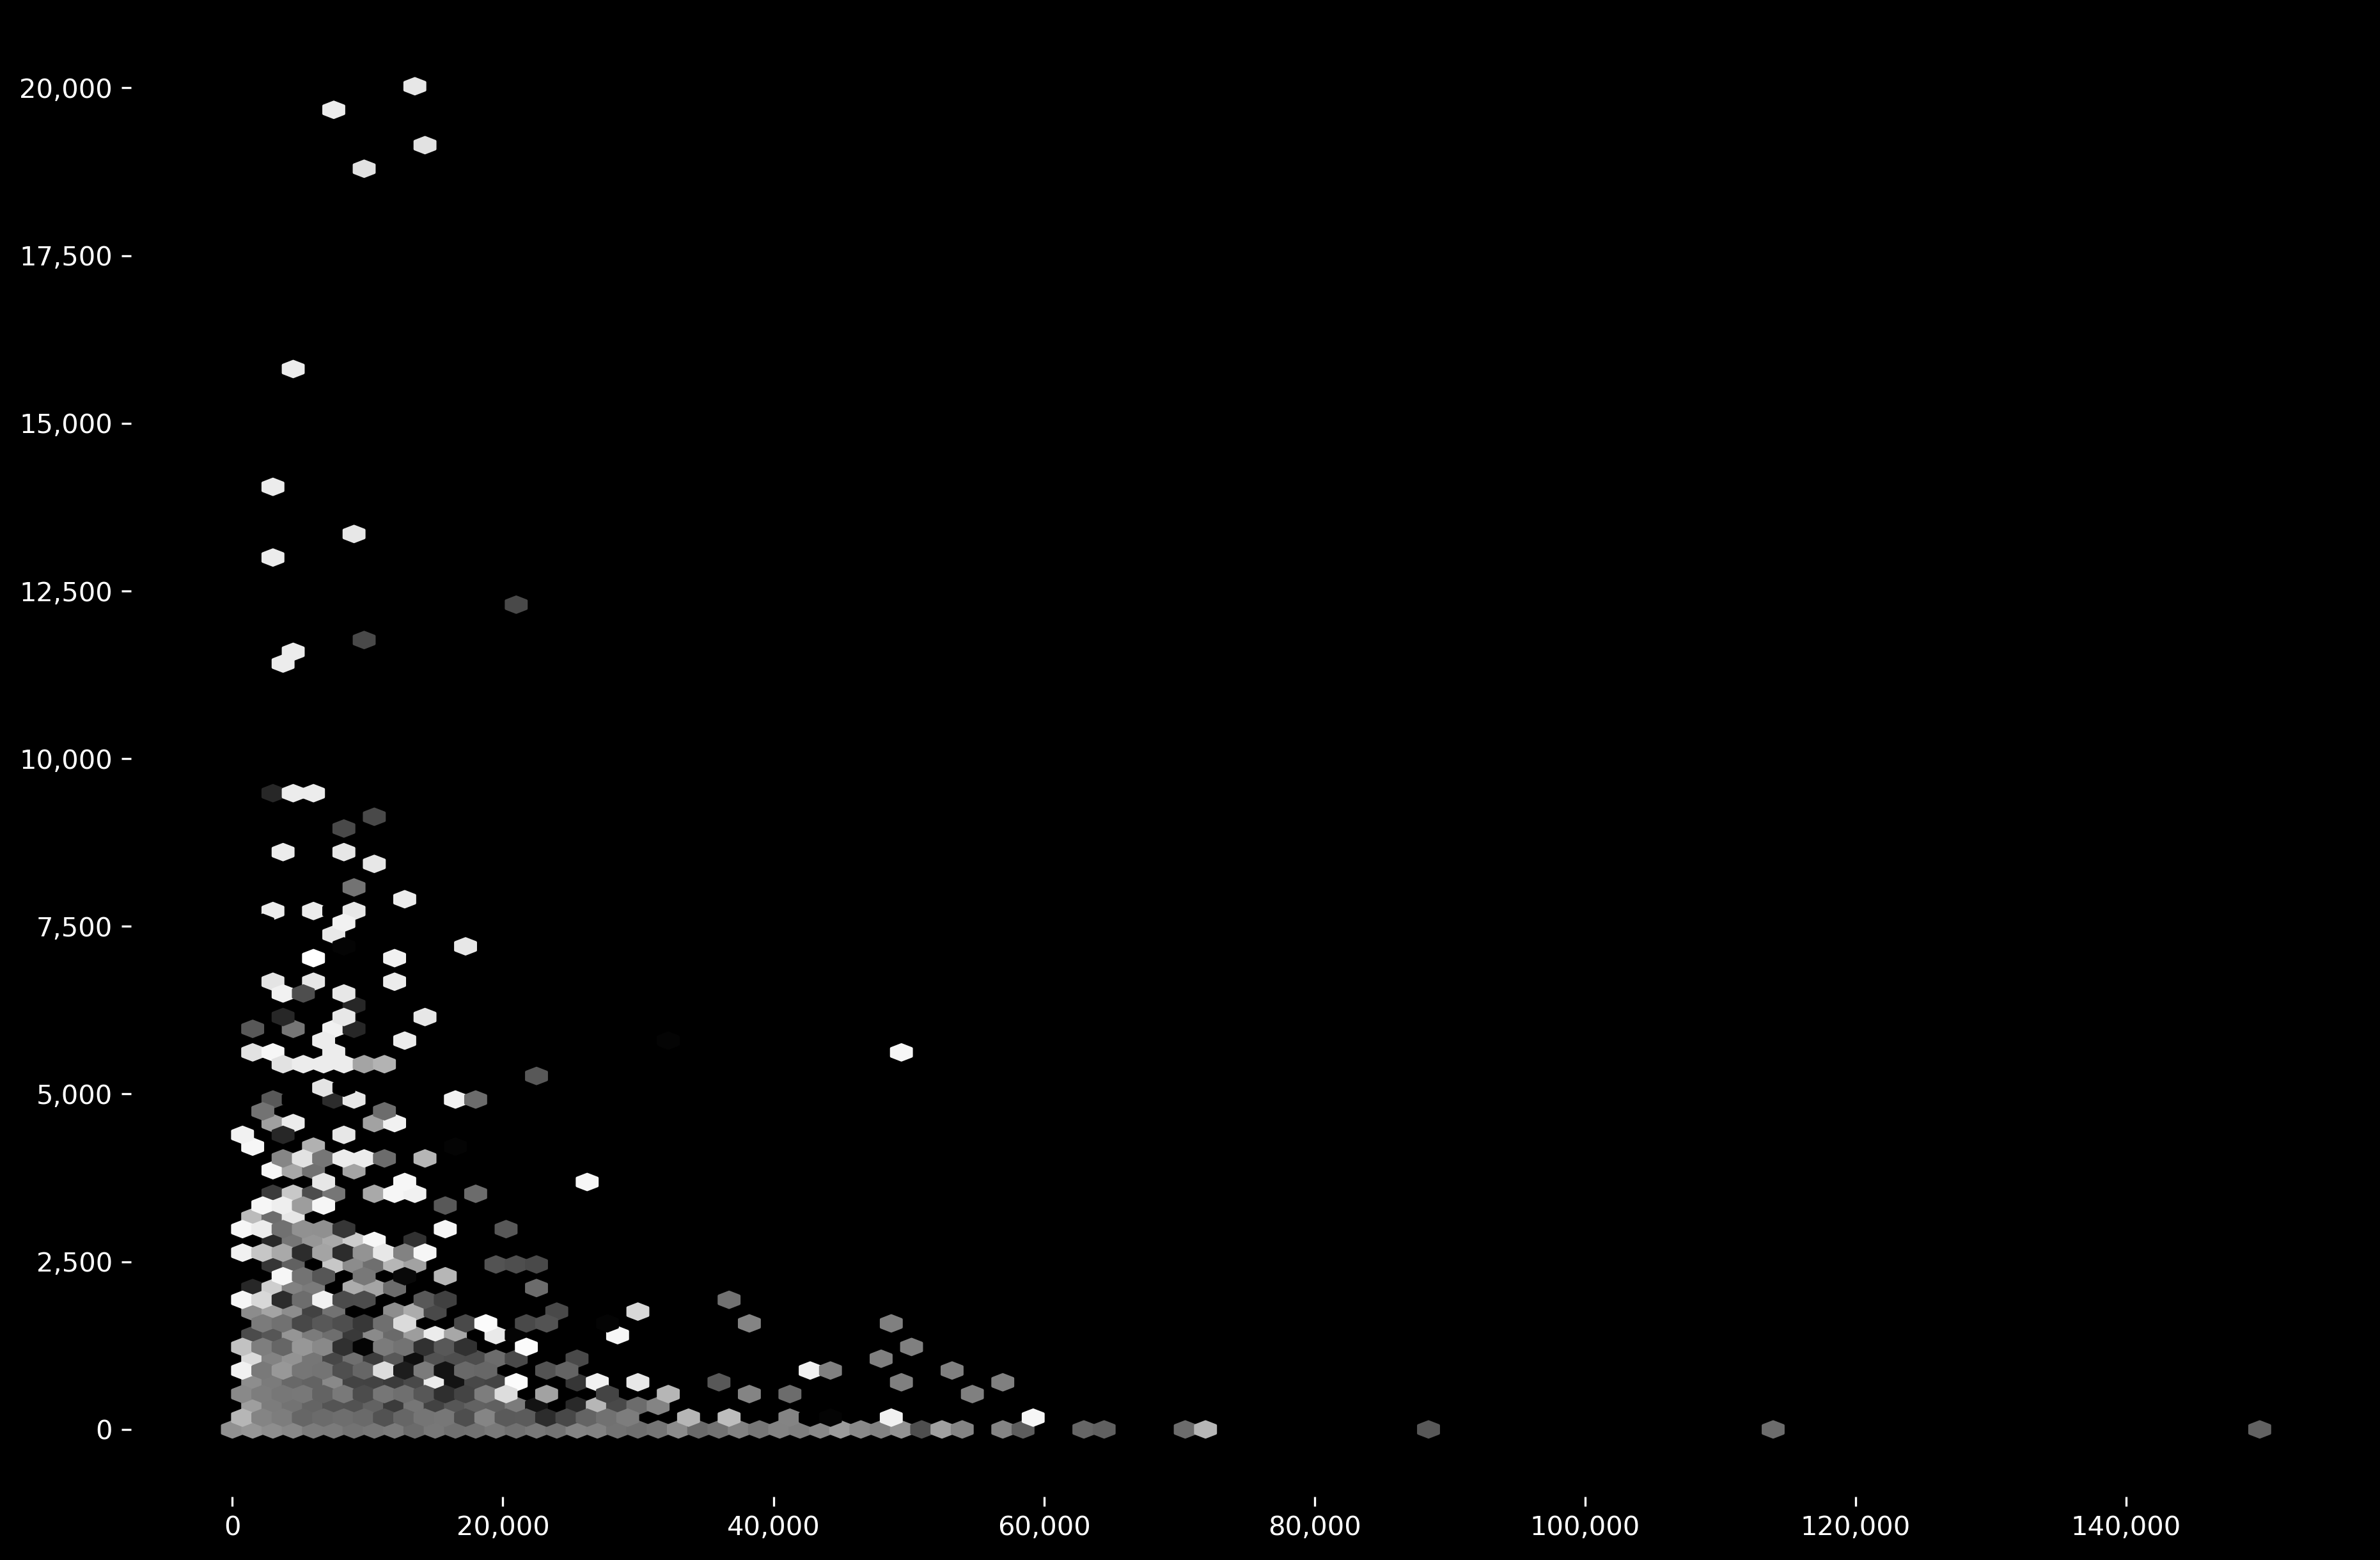

In [13]:
# Create a hexbin plotting memory variability per hour vs. unresponsive counts.
memory_doesnt_respond = vague_memory_by_hour.merge(unending, on = 'Hour')
x = memory_doesnt_respond['Std. Dev. of Total Memory Per Core']
y = memory_doesnt_respond['Unresponsive Counts']
make_a_hexbin(x, y)

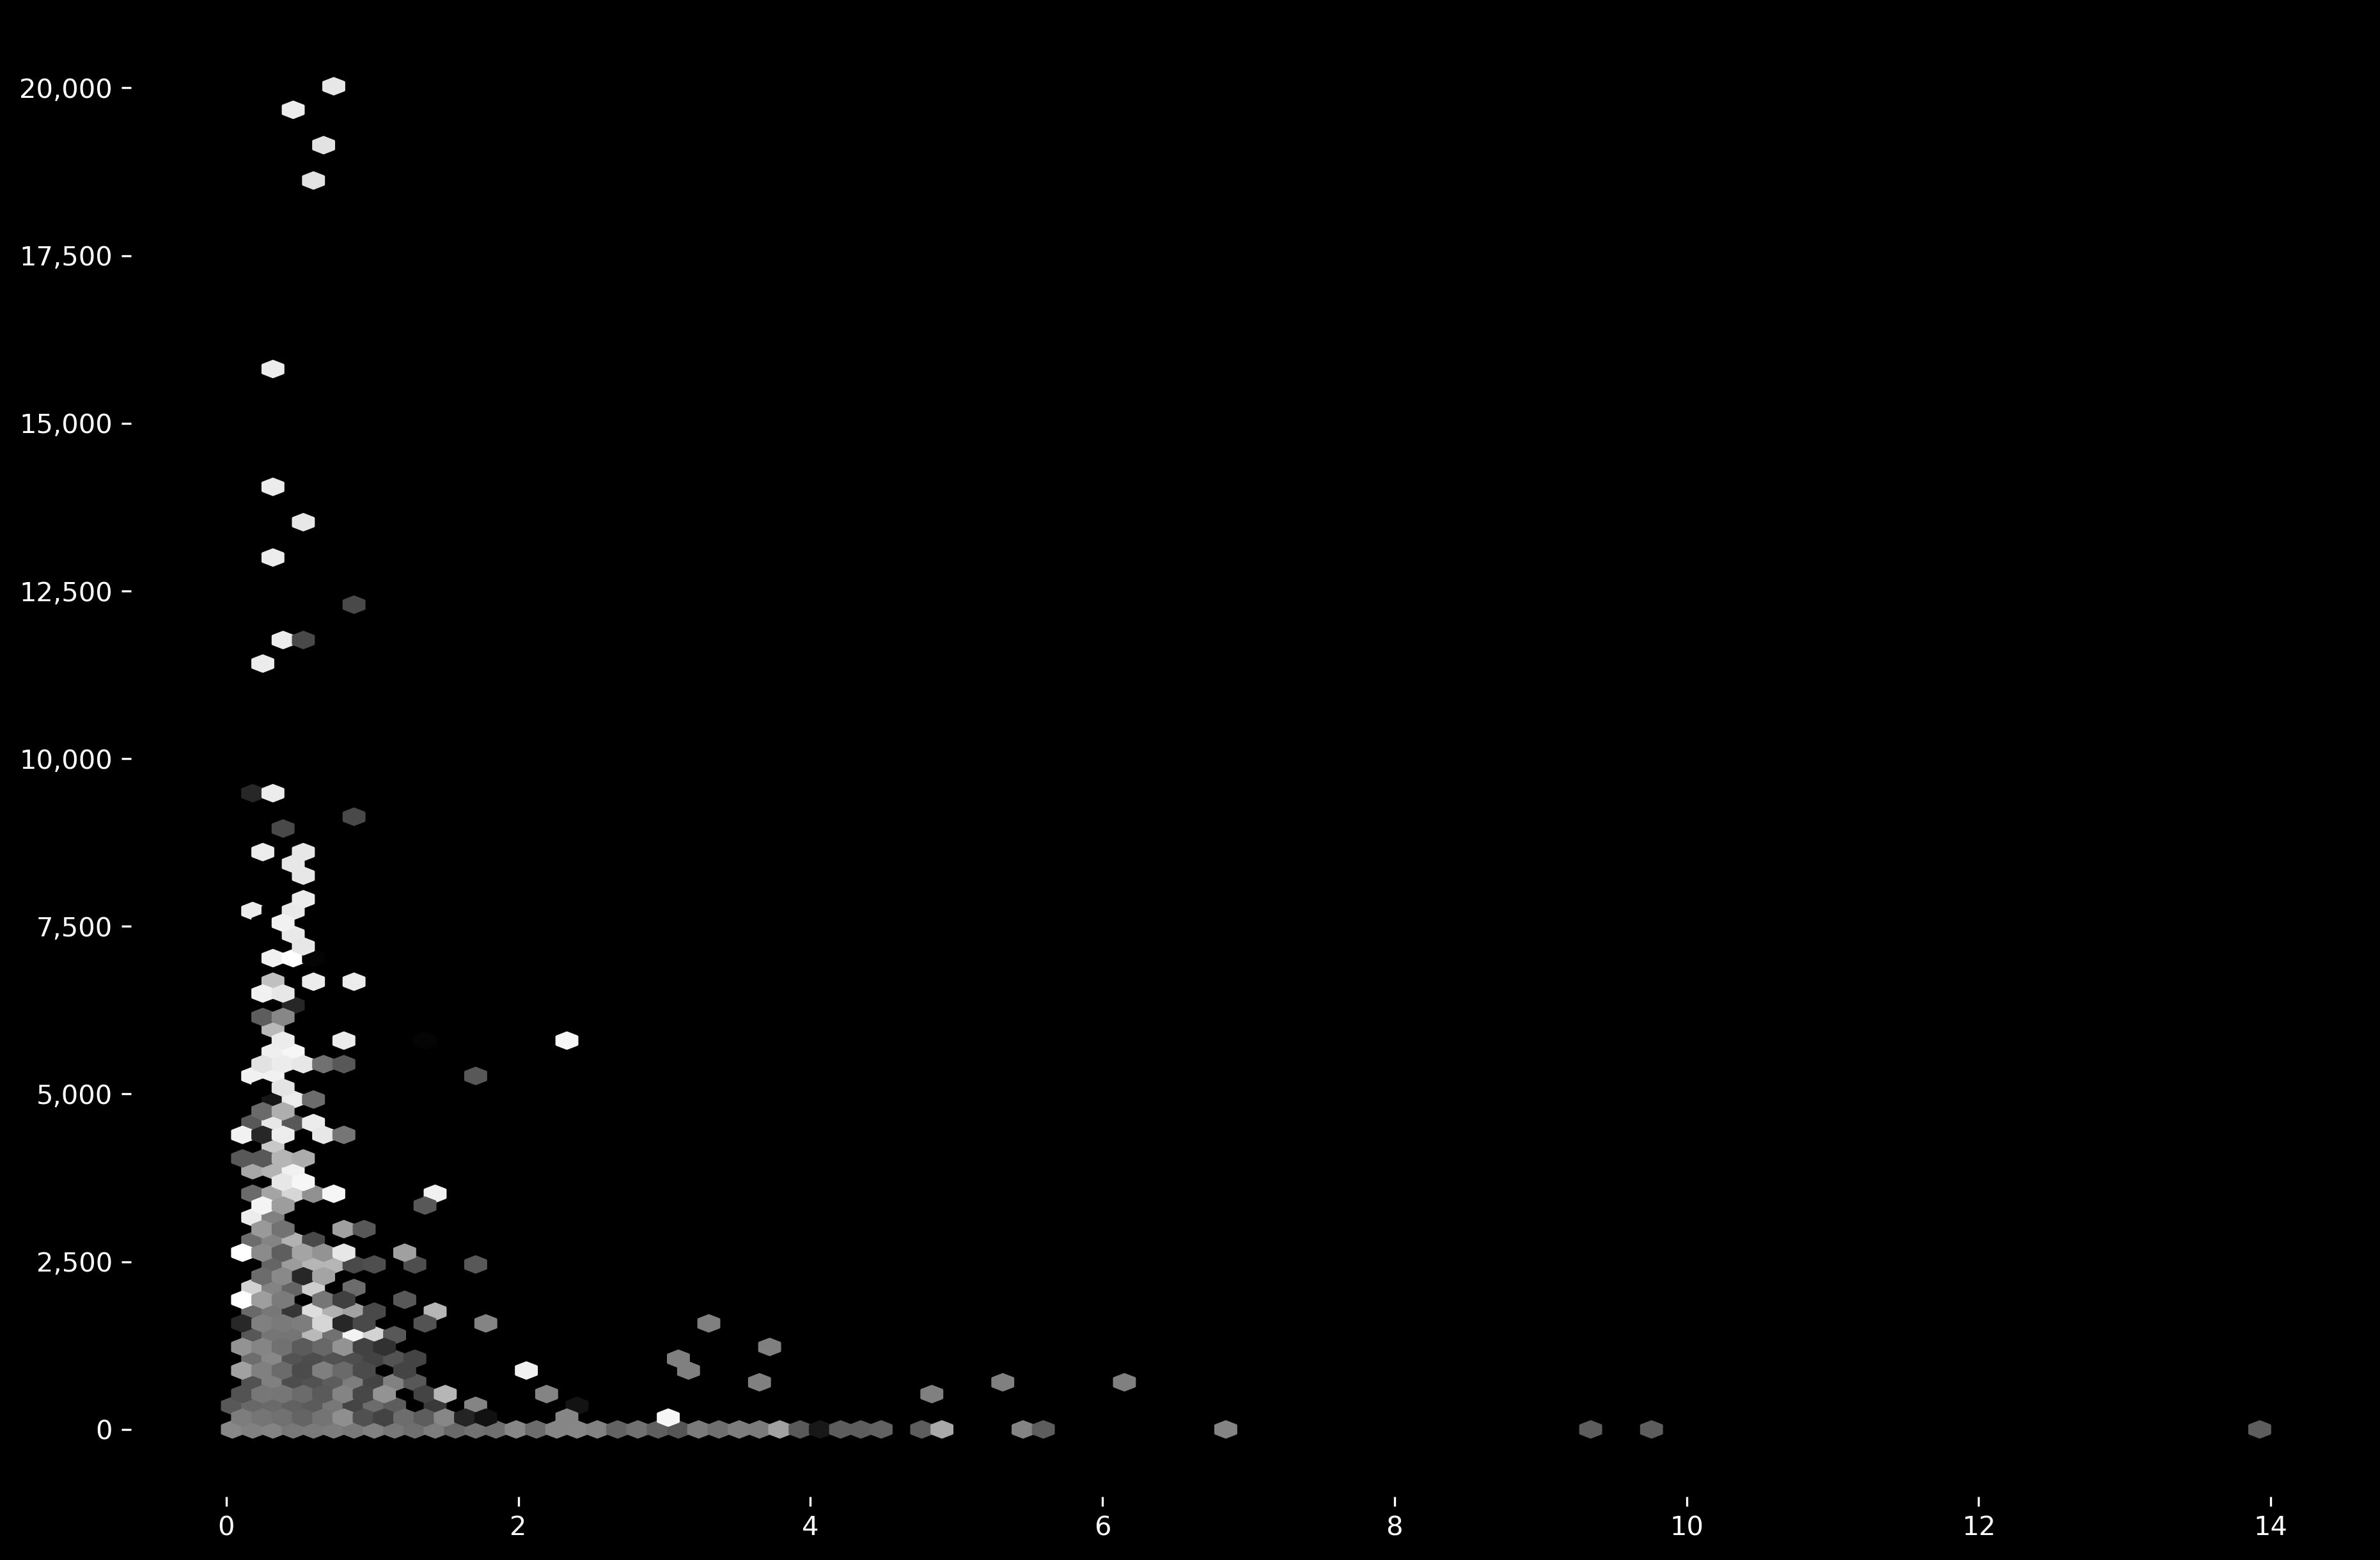

In [14]:
# Take the absolute value of the zscores of used memory per core.
vague_memory['ABSUMPCZS'] = abs(zscore(vague_memory['USEDMEMPERCORE'], ddof = 1))

# Group absolute value of zscores by hour then sum, mean for that timeframe.
zscores_by_hour = (
    vague_memory.set_index('END').\
    groupby(pd.Grouper(freq = 'H'))['ABSUMPCZS'].\
    agg(['sum','mean']).\
    reset_index().\
    rename(columns = {'END':'Hour',
                      'sum':'Total Z-Score for Jobs That Hour',
                      'mean':'Avg Z-Score for Jobs That Hour'}))

# Create a total z-score for jobs in a hour vs. unresponsive counts.
zscore_doesnt_respond = zscores_by_hour.merge(unending, on = 'Hour')
zscore_series = zscore_doesnt_respond['Avg Z-Score for Jobs That Hour']
uc_series = zscore_doesnt_respond['Unresponsive Counts']

x_coords = zscore_series.apply(lambda x: (x - zscore_series.min()/(zscore_series.max() - zscore_series.min())))
y_coords = uc_series.apply(lambda x: (x - uc_series.min()/(uc_series.max() - uc_series.min())))
make_a_hexbin(x_coords, y_coords)

In [15]:
# Pull all variables that can be made into numeric variables for correlation heatmap purposes.
pearson_pull = (
    pd.read_sql("SELECT USEDMEMPERCORE,\
    REQMEMPERCORE,\
    REQTIME,\
    USEDTIME,\
    STRFTIME('%Y-%m-%dT%H:%M:%S', END) AS END FROM jobs_corrected",
                con = connection,
                parse_dates = ['END'])
)

# Create dataframe of endtimes to merge in as well.
endtimes = pearson_pull[['END']]
endtimes['ENDCOUNTS'] = ''
endtimes = endtimes.set_index('END').resample('1H').count().reset_index()

pearson_pull_slurm = (
    pd.read_sql("SELECT UNRESPONSIVE,\
    COMMANDCOUNT,\
    STRFTIME('%Y-%m-%dT%H:%M:%S', DATETIME) AS DATETIME FROM slurm_corrected",
                con = connection,
                parse_dates = ['DATETIME'])
)

# Sort the pull columns by hour.
pearson_pull_by_hour = (
    pearson_pull.set_index('END').\
    groupby(pd.Grouper(freq = 'H'))[[i for i in pearson_pull.columns if i != 'END']].\
    agg(['sum']).\
    reset_index())

pearson_pull_slurm_by_hour = (
    pearson_pull_slurm.set_index('DATETIME').\
    groupby(pd.Grouper(freq = 'H'))[[i for i in pearson_pull_slurm.columns if i != 'DATETIME']].\
    agg(['sum']).\
    reset_index())

In [16]:
# General clean-up to get rid of multi-indexes.
pearson_pull_slurm_by_hour.columns = pearson_pull_slurm_by_hour.columns.map('_'.join)

pearson_pull_slurm_by_hour = (
    pearson_pull_slurm_by_hour[['DATETIME_',
                                'UNRESPONSIVE_sum',
                                'COMMANDCOUNT_sum']].\
    rename(columns = {'DATETIME_':'DATETIME',
                      'UNRESPONSIVE_sum':'UNRESPONSIVE',
                      'COMMANDCOUNT_sum':'COMMANDCOUNT'}))

pearson_pull_by_hour.columns = pearson_pull_by_hour.columns.map('_'.join)

pearson_pull_by_hour = (
    pearson_pull_by_hour[['END_',
                          'USEDMEMPERCORE_sum',
                          'REQMEMPERCORE_sum',
                          'REQTIME_sum',
                          'USEDTIME_sum']].\
    rename(columns = {'END_':'END',
                      'USEDMEMPERCORE_sum':'USEDMEMPERCORE',
                      'REQMEMPERCORE_sum':'REQMEMPERCORE',
                      'REQTIME_sum':'REQTIME',
                      'USEDTIME_sum':'USEDTIME'}))

# Merge each hour sorted data frame together and pull out time.
ppmergeptone = pearson_pull_slurm_by_hour.merge(endtimes, left_on = 'DATETIME', right_on = 'END')
ppmergeptone = ppmergeptone[[i for i in ppmergeptone.columns if i != 'DATETIME']]
ppmerge = pearson_pull_by_hour.merge(ppmergeptone, on = 'END')
ppmergewotime = ppmerge[['USEDMEMPERCORE',
                         'REQMEMPERCORE',
                         'REQTIME',
                         'USEDTIME',
                         'UNRESPONSIVE',
                         'COMMANDCOUNT',
                         'ENDCOUNTS']]

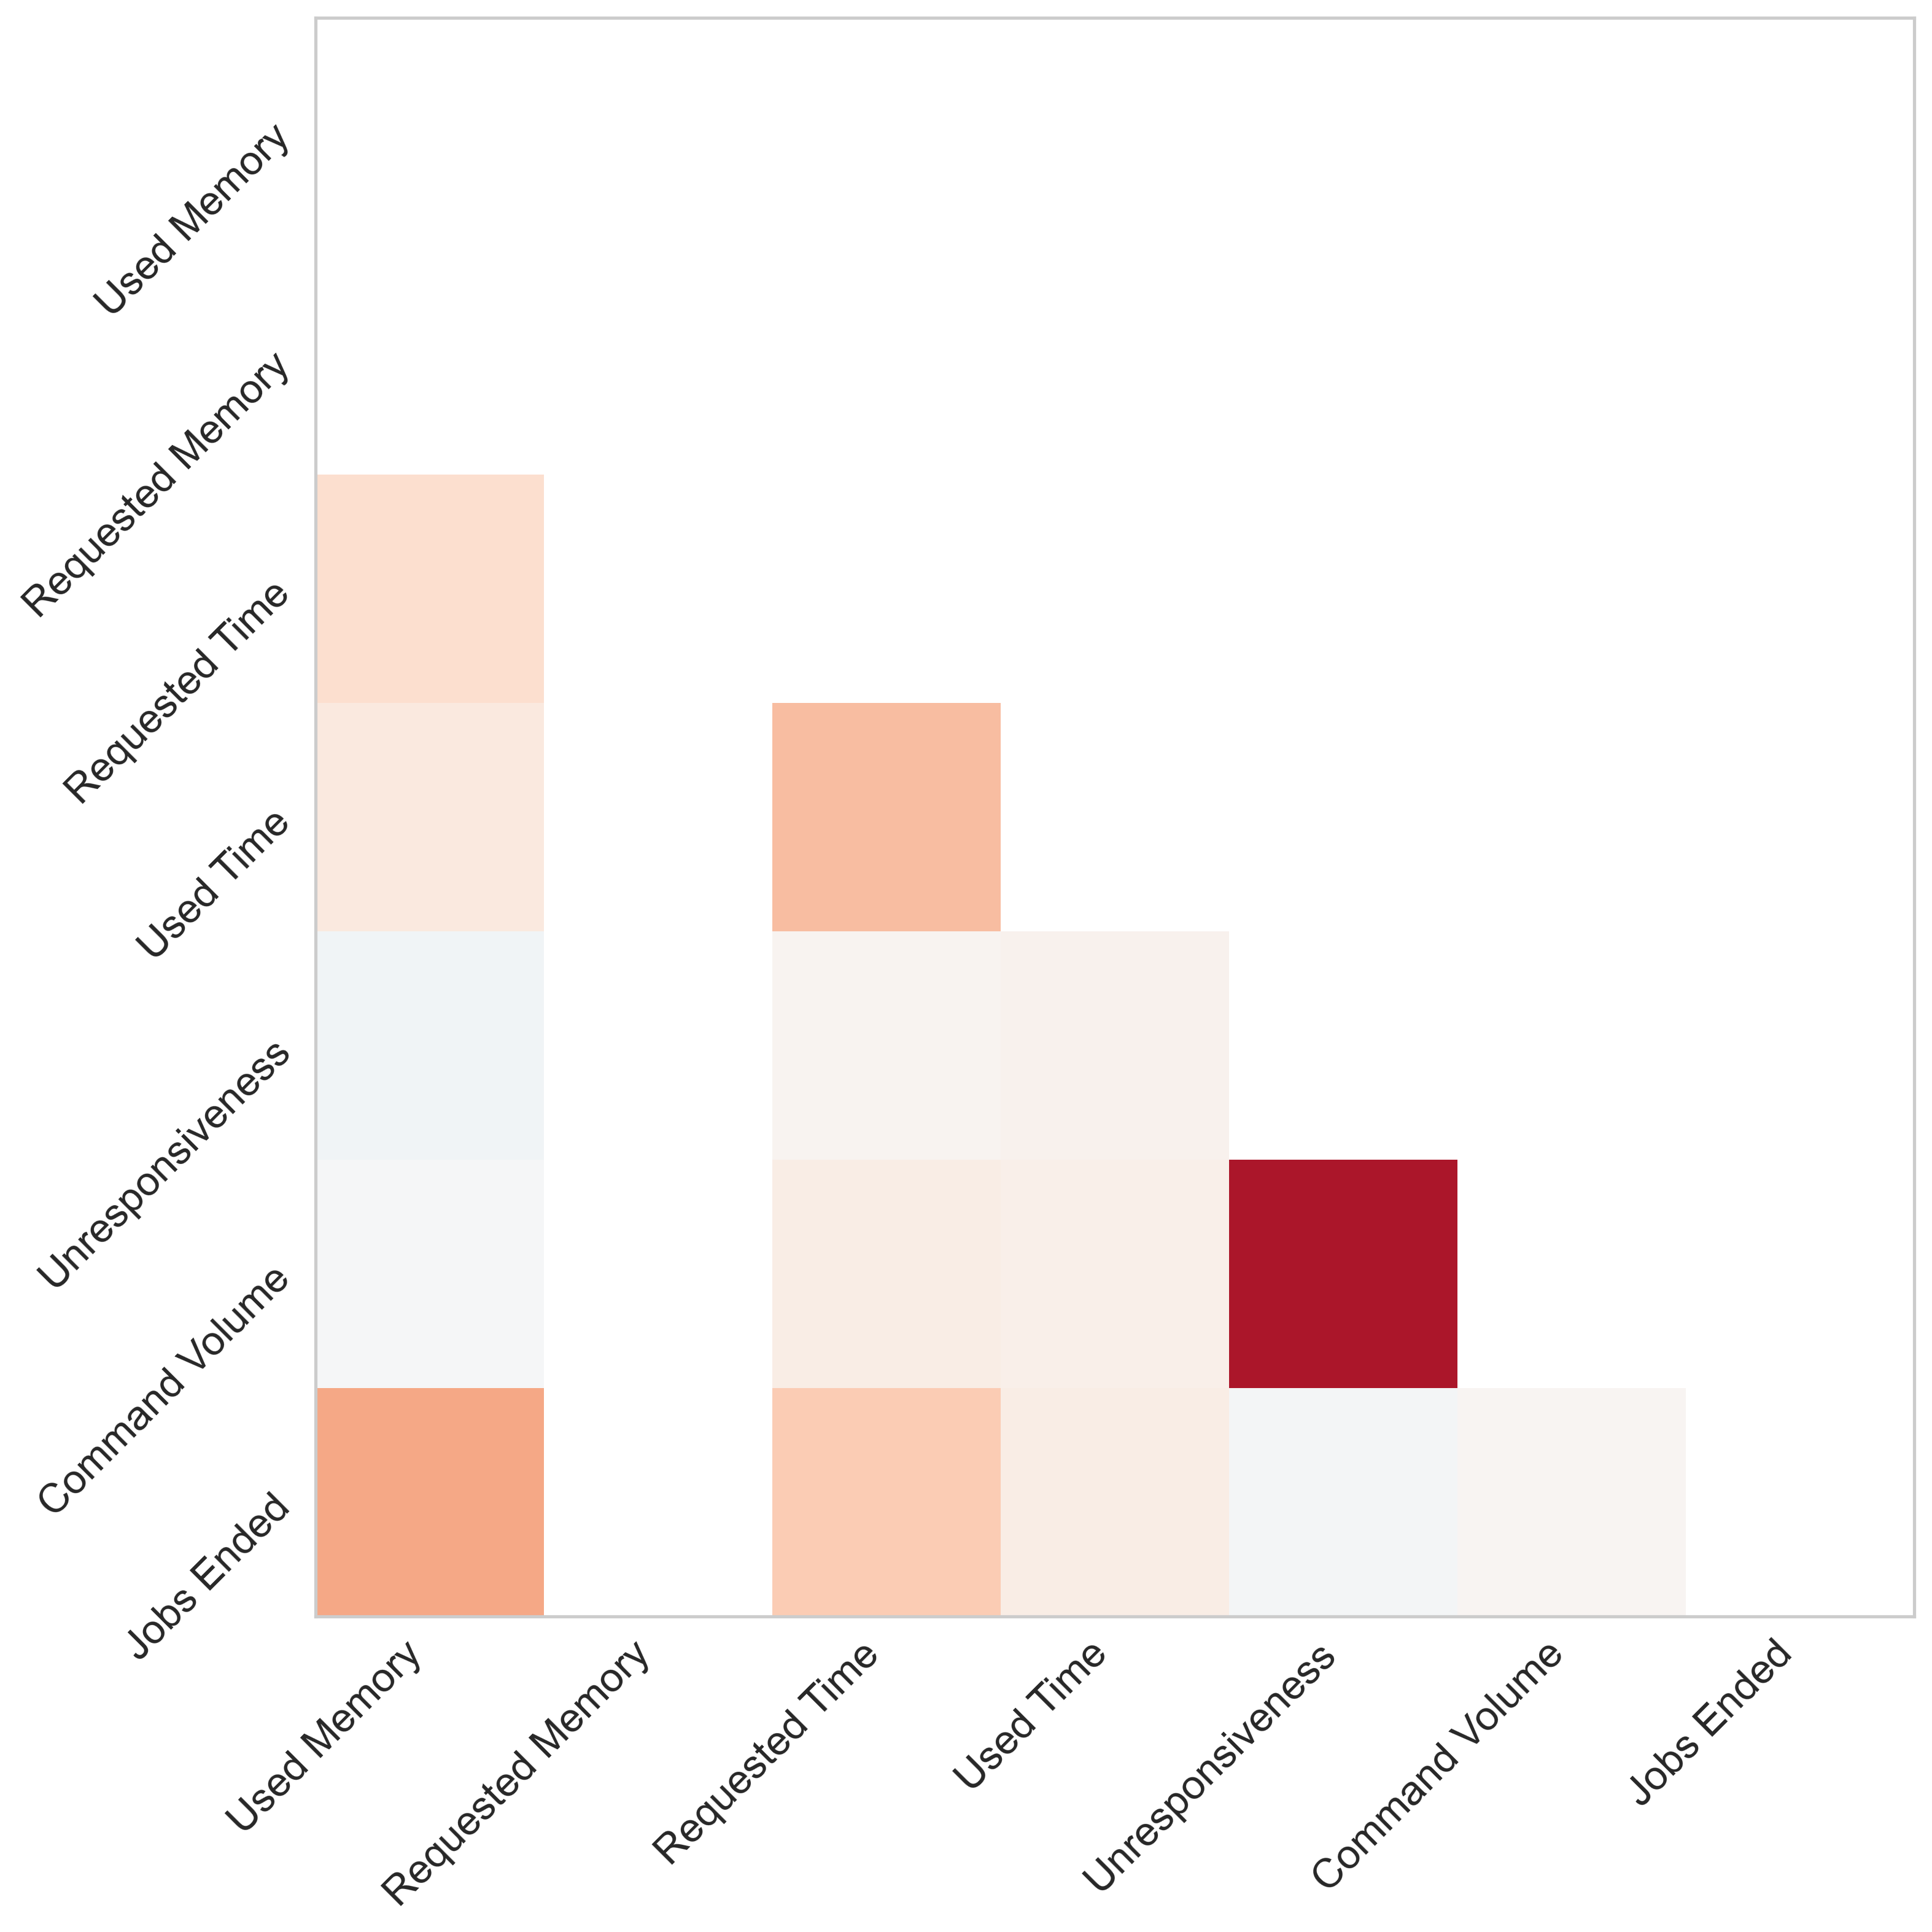

In [72]:
# Later import due to effects on matplotlib.
from yellowbrick.features import Rank2D

# Plot Pearson correlation heatmap.
fig, ax = plt.subplots(figsize = (14, 12), dpi = 300)

corrheatmap = Rank2D(algorithm = "pearson",
                     features = ['Used Memory',
                                 'Requested Memory',
                                 'Requested Time',
                                 'Used Time',
                                 'Unresponsiveness',
                                 'Command Volume',
                                 'Jobs Ended'],
                     ax = ax)
corrheatmap.fit_transform(ppmergewotime)
corrheatmap.set_title('')
fig.delaxes(fig.axes[1])
plt.xticks(fontsize = 16, rotation = 45, ha = 'right')
plt.yticks(fontsize = 16, rotation = 45, ha = 'right')
plt.savefig('images/Correlation.png', dpi = 300, transparent = True);